## LSTM Network Training

In [13]:
import os
import warnings
import pandas as pd

from src.StockPredictionConfig import StockPredictionConfig
from src.StockDataProcessor import StockDataProcessor
from src.LongShortTermMemory import LSTMModel

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or '3' to suppress all messages

# Suppress other warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")

from datetime import timedelta

In [2]:
# for combined per-day and per-minute interval data
# FOLDER_PREFIX = "data/comb/"
# TIME_STEPS = 60
# PREDICTION_RANGE = 60 # *24

In [3]:
# for per-minute interval data
# FOLDER_PREFIX = "data/min/"
# TIME_STEPS = 60
# PREDICTION_RANGE = 60

In [4]:
# for per-day interval data
FOLDER_PREFIX = "data/day/"
TIME_STEPS = 1
PREDICTION_RANGE = 5

In [18]:
# import secrets
# TODAY_RUN = datetime.today().strftime(DATE_FORMAT)
# TOKEN = '_' + TODAY_RUN + '_' + secrets.token_hex(16)
TOKEN = ""

In [26]:
STOCK_TICKER = "GOOG"
EPOCHS = 100
BATCH_SIZE = 10
TRAIN_DATA_SPLIT = 0.6
RUN_FOLDER = f"{FOLDER_PREFIX}{STOCK_TICKER}{TOKEN}/"
WORK_DIR = os.path.join(os.getcwd(), RUN_FOLDER)
CSV_FILE = f"{WORK_DIR}data.csv"

PROJECT_FOLDER = os.path.join(os.getcwd(), RUN_FOLDER)
if not os.path.exists(PROJECT_FOLDER):
    os.makedirs(PROJECT_FOLDER)

In [37]:
# STOCK_START_DATE = pd.to_datetime("2017-06-07")
# STOCK_VALIDATION_DATE = pd.to_datetime("2022-06-07")
# STOCK_END_DATE = pd.to_datetime("2024-06-07")

data = pd.read_csv(CSV_FILE)
first_and_last_rows = data.iloc[[0, -1]]

STOCK_START_DATE = pd.to_datetime(first_and_last_rows.iloc[0]['Datetime'])
total_number_of_rows = len(data)
validation_date_index = int(total_number_of_rows * TRAIN_DATA_SPLIT)

STOCK_VALIDATION_DATE = pd.to_datetime(data.iloc[validation_date_index]['Datetime'])
STOCK_END_DATE = pd.to_datetime(first_and_last_rows.iloc[1]['Datetime'])

In [38]:
# DATE_FORMAT = "%Y-%m-%d"
# .strftime(DATE_FORMAT)
print('Ticker: ' + STOCK_TICKER)
print('Start Date: ' + STOCK_START_DATE.__str__())
print('Validation Date: ' + STOCK_VALIDATION_DATE.__str__())
print('End Date: ' + STOCK_END_DATE.__str__())
print('Test Run Folder: ' + RUN_FOLDER)

Ticker: GOOG
Start Date: 2017-06-07 00:00:00
Validation Date: 2021-08-18 00:00:00
End Date: 2024-06-07 00:00:00
Test Run Folder: data/day/GOOG/


In [8]:
(x_train, y_train), (x_test, y_test), (training_data, test_data) = StockDataProcessor.load_csv_transform_to_numpy(TIME_STEPS, CSV_FILE, STOCK_VALIDATION_DATE)

mean: [0.32731816]
max: 0.9999999999999999
min: 0.0
Std dev: [0.30543526]


In [7]:
stock_config = StockPredictionConfig(STOCK_TICKER, 
                                   STOCK_START_DATE,
                                   STOCK_END_DATE,
                                   STOCK_VALIDATION_DATE, 
                                   PROJECT_FOLDER, 
                                   EPOCHS,
                                   TIME_STEPS,
                                   TOKEN,
                                   BATCH_SIZE)

### Train

mean: [0.32731816]
max: 0.9999999999999999
min: 0.0
Std dev: [0.30543526]
Epoch 1/100


2024-06-26 15:39:13.210359: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-26 15:39:13.216969: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-26 15:39:13.217043: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-26 15:39:13.219477: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-26 15:39:13.219565: I external/local_xla/xla/stream_executor

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - MSE: 0.1229 - loss: 0.1229 - val_MSE: 0.0134 - val_loss: 0.0134
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - MSE: 0.0122 - loss: 0.0122 - val_MSE: 0.0025 - val_loss: 0.0025
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - MSE: 0.0110 - loss: 0.0110 - val_MSE: 0.0025 - val_loss: 0.0025
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - MSE: 0.0088 - loss: 0.0088 - val_MSE: 0.0022 - val_loss: 0.0022
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - MSE: 0.0083 - loss: 0.0083 - val_MSE: 9.8465e-04 - val_loss: 9.8465e-04
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - MSE: 0.0066 - loss: 0.0066 - val_MSE: 0.0029 - val_loss: 0.0029
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - MSE: 0.0062 - loss: 0.0062 - val_MSE: 0.0013 - val_loss: 0.0013
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - MSE: 0.0062 - loss: 0.0062 - val_MSE: 0.0010 - val_loss: 0.0010
Epoch 8: early stopping
saving weights
displ

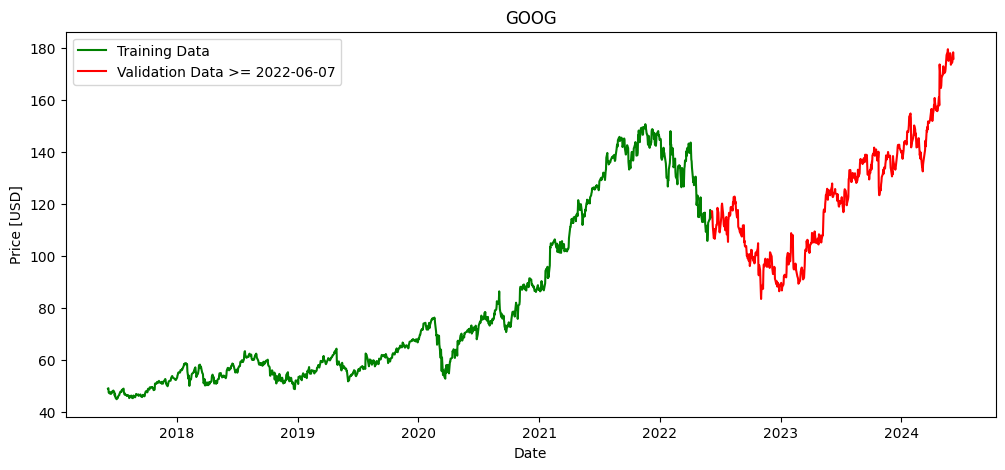

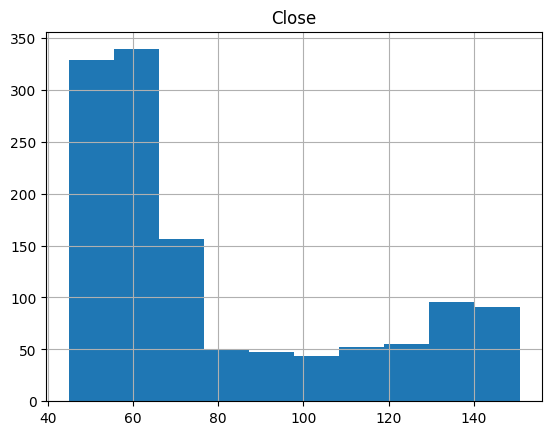

plotting loss


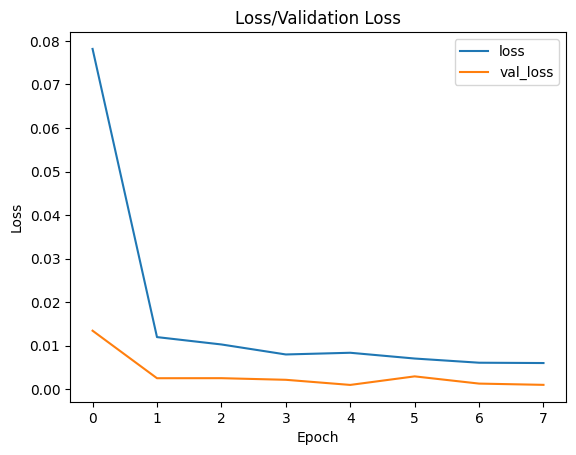

plotting MSE


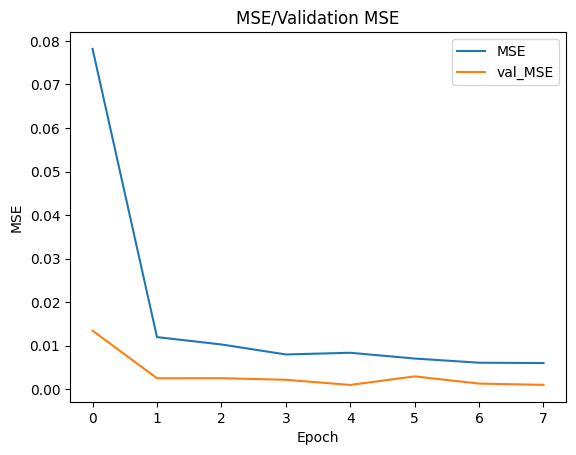

plotting prediction results
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
plotting predictions
Index(['Predicted_Price'], dtype='object')


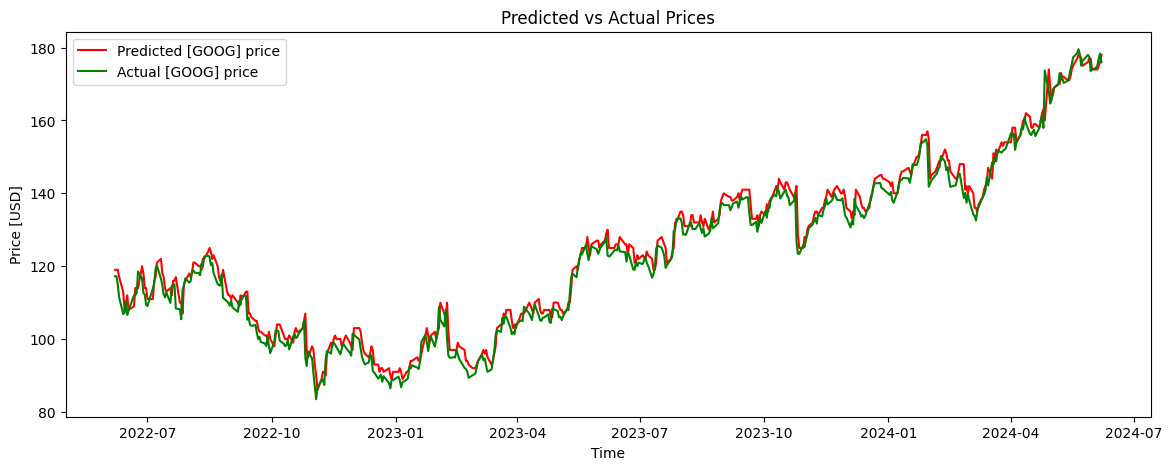

prediction is finished


In [9]:
# Execute Deep Learning model
lstm = LSTMModel(stock_config.project_folder)
lstm.Train(stock_config, x_train, y_train, x_test, y_test, training_data, test_data)

## Prediction

In [10]:
data = pd.read_csv(CSV_FILE)

latest_close_price = data['Close'].iloc[-1]
latest_date = data['Datetime'].iloc[-1]

print(f"{latest_close_price}: latest_close_price")
print(f"{latest_date}: latest_date")

start_date = pd.to_datetime(latest_date) + timedelta(1)
end_date = pd.to_datetime(start_date) + timedelta(PREDICTION_RANGE)

print(f"{start_date}: start_date")
print(f"{end_date}: end_date")

175.9499969482422: latest_close_price
2024-06-07: latest_date
2024-06-08 00:00:00: start_date
2024-06-13 00:00:00: end_date


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 100)            │     40,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 1, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 50)             │     30,200 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 50)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 50)             │     20,200 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 50)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)                │     20,200 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_3 (Dropout)             │ (None, 50)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 1)                 │         51 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 334,355 (1.28 MB)

 Trainable params: 111,451 (435.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 222,904 (870.72 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
plotting future predictions


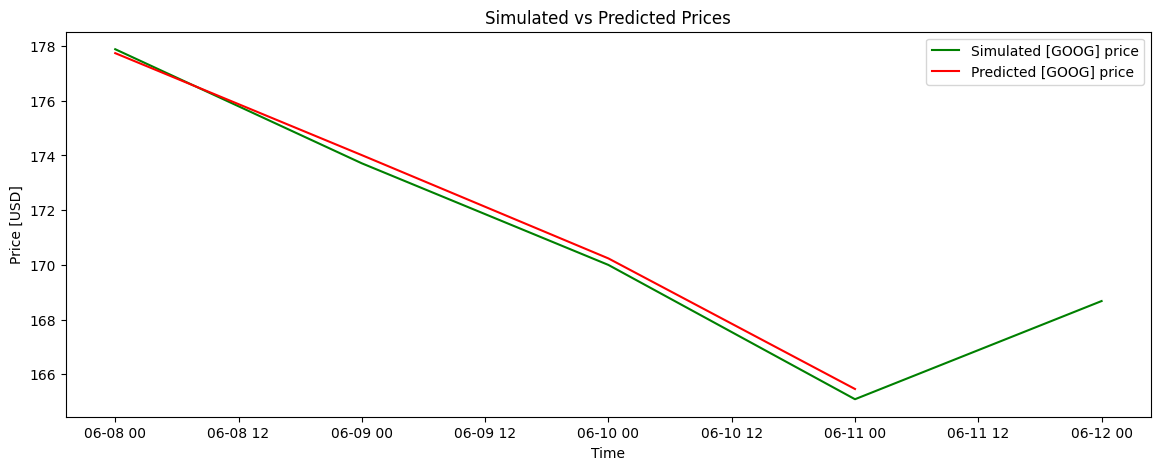

In [11]:
lstm.Infer(start_date, end_date, latest_close_price, WORK_DIR, TIME_STEPS, STOCK_TICKER, stock_config.CURRENCY)